In [9]:
import pandas as pd
import datasets
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from backend.data_utils import create_dataset
from functools import partial


CACHE_DIR = 'data'
model_name = "google-bert/bert-base-cased"

## About data

**Named Entity Recognition in Twitter: A Dataset and Analysis on Short-Term Temporal Shifts, AACL main conference 2022**

NER dataset on Twitter with 7 entity labels. Each instance of TweetNER7 comes with a timestamp which distributes from September 2019 to August 2021.

Entity Types: 
* corperation, 
* creative_work, 
* event, 
* group, 
* location, 
* product, 
* person

## Loading datasets

In [8]:
all_datasets = datasets.load_dataset('tner/tweetner7', cache_dir=CACHE_DIR)
train_dataset = all_datasets['train_all']
val_dataset = datasets.concatenate_datasets([all_datasets[ 'validation_2020'], all_datasets['validation_2021']])
test_dataset = datasets.concatenate_datasets([all_datasets['test_2020'], all_datasets['test_2021']])

Generating extra_2021 split: 100%|██████████| 93594/93594 [00:00<00:00, 708938.06 examples/s]


In [21]:
label_2_id = {
                 "B-corporation": 0,
                 "B-creative_work": 1,
                 "B-event": 2,
                 "B-group": 3,
                 "B-location": 4,
                 "B-person": 5,
                 "B-product": 6,
                 "I-corporation": 7,
                 "I-creative_work": 8,
                 "I-event": 9,
                 "I-group": 10,
                 "I-location": 11,
                 "I-person": 12,
                 "I-product": 13,
                 "O": 14
             }

id_2_label = {v: k for k, v in label_2_id.items()}

def to_bio(row, labels_mapping: dict):
    bio_labels = []
    for label in row['tags']:
        bio_labels.append(labels_mapping[label])
    row['bio_labels'] = bio_labels
    return row

converter_fn = partial(to_bio, labels_mapping={v: k for k, v in label_2_id.items()})
train_dataset = train_dataset.map(converter_fn)
val_dataset = val_dataset.map(converter_fn)
test_dataset = test_dataset.map(converter_fn)

Map: 100%|██████████| 3383/3383 [00:00<00:00, 18293.35 examples/s]


In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, clean_up_tokenization_spaces=False)

id_2_label = {v: k.split('-')[-1] for k, v in label_2_id.items() if k.startswith('B')}

labels_list = ['corporation', 'creative_work', 'event', 'group', 'location', 'person', 'product']
global_metrics = ['overall_precision', 'overall_recall', 'overall_f1', 'overall_accuracy']

train_dataset_tokenized = create_dataset(train_dataset, f'{CACHE_DIR}/train_all_tokenized.csv', tokenizer, max_len=512)
val_dataset_tokenized = create_dataset(val_dataset, f'{CACHE_DIR}/val_all_tokenized.csv', tokenizer, max_len=512)
test_dataset_tokenized = create_dataset(test_dataset, f'{CACHE_DIR}/test_all_tokenized.csv', tokenizer, max_len=512)

Start data processing...
Start data processing...
Start data processing...


## General Data Description

First, let's examine what texts and their annotation looks like

In [28]:
num_examples = 5
for document in range(num_examples):
  # beginning = random.randint(0, len(train_data.tokens[document]) - 16)
  beginning = 0
  ending = beginning + 20

  print(f'Document {document}, tokens from {beginning} to {ending}:')
  print(
      pd.DataFrame(
          {
              'tokens:': train_dataset["tokens"][document][beginning:ending],
              'tags:': list(map(lambda x: id_2_label[x], train_dataset["tags"][document][beginning:ending])),
          }
      )
      .transpose()
      .to_string(index=True, header=False),
      '\n'
  )

Document 0, tokens from 0 to 20:
tokens:  Morning  5km  run  with  {{USERNAME}}  for  breast  cancer  awareness  #  pinkoctober  #  breastcancerawareness  #  zalorafit  #  zalorafitxbnwrc  @  The     Central
tags:          O    O    O     O             O    O       O       O          O  O      B-event  O                B-event  O          O  O                O  O    O  B-location 

Document 1, tokens from 0 to 20:
tokens:  President     Trump  Arrives  at            UFC            244  in         New        York  to  Cheers  from  Crowd  (  VIDEO  )  {{URL}}  via  {{USERNAME}}
tags:     B-person  I-person        O   O  B-corporation  I-corporation   O  B-location  I-location   O       O     O      O  O      O  O        O    O             O 

Document 2, tokens from 0 to 20:
tokens:  "  I  've  been  in  law  enforcement  for  23  years  .  I  've  never  seen  this  in  this  city  and
tags:    O  O    O     O   O    O            O    O   O      O  O  O    O      O     O     O   O     

To gain a better insight into the meaning of each category, let's draw a few examples:

In [38]:
train_df = pd.DataFrame(train_dataset)
train_df['labels'] = train_df.tags.apply(lambda text: [id_2_label[token] for token in text])

In [39]:
labels = set([
    label.split('-')[-1]
    for annot in train_df.labels
    for label in annot
]) - {'O'}


def get_examples(label: str, num_examples: int):
  examples = []
  for document in range(0, train_df.shape[0]):
    if len(examples) >= num_examples:
      return examples
    try:
      beginning = train_df.labels[document].index(f'B-{label}')
    except ValueError:
      continue

    example = train_df.tokens[document][beginning].strip()
    for token_id in range(beginning + 1, len(train_df.tokens[document]) - 1):
      if train_df.labels[document][token_id] == f'I-{label}':
        example += ' ' + train_df.tokens[document][token_id].strip()
    examples.append(example)

  print(f'WARNING: could not find {num_examples} examples for label {label}, found {len(examples)} examples')
  return examples


label_examples = {}
for label in labels:
  label_examples[label] = get_examples(label=label, num_examples=10)

In [40]:
pd.DataFrame(dict([(k, pd.Series(v)) for k, v in label_examples.items()])).T

,0,1,2,3,4,5,6,7,8,9
corporation,UFC 244,Buffalo Police,Eyewitness News WTVO WQRF,{@SERA - Labour's Environment Campaign@},twitch,iTunes,{@Global Kingston@},MMA,Blue Mountains,NBA
location,"Central Park , Desa Parkcity",New York,Salo,Uplands Parks,NYC,{@St. Lawrence College@},Japan Africa,Louisiana coast,The Irish Corner Limited,UK-based
creative_work,Itchy and Scratchy Simpsons Simpsons,Supporting Nature,Warzone,Make Christmas Great Again 6-Pack Buttons,Above the Rain,Star Wars,Probe the Act 2,ship,AfterLife,His fights
group,Rams,Lavanderboyz chillcast,StrayKidsComback,{@One Direction@},BROWNS,Lakers,Hurricane Center,"{@Higher Education Department, MP@}",Liverpool Vs Man United,Thecollaroyboys
person,President Trump,Jeff Rinaldo,Bart,{@Daniel Zeichner@},Trump,Popsd,SadGuru Ji Maharaj,Goff,{@Chadwick Boseman@},{@Carla Esparza@}
event,pinkoctober,Buffalo,3-nations final game,fringe event,Smallstreamerconnect,Christmas parties Christmas,Bball,{@Rugby World Cup@},thanksgiving,climatechange
product,{@Google News@},Mayo Breast Cancer Vaccine,{@YouTube@},floorball,Red and Green Festive Color Badges,{@DistroKid@},recording,CUSTOM BROWNS ATTIRE,Social Security Fund,{@CBS News@}


## Quantitative description

### Length distribution

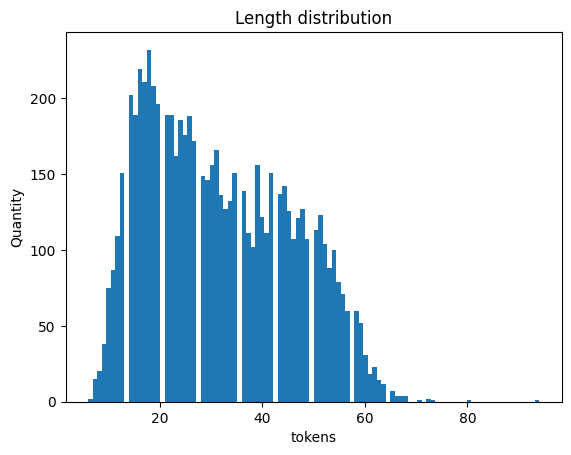

In [41]:
train_df.tokens.apply(len).plot.hist(title='Length distribution', xlabel='tokens', ylabel='Quantity', bins=100);

In [ ]:
train_df["labels"] = train_df.labels.apply(lambda text: [i.split('-')[-1] if not i == 'O' else i for i in text])

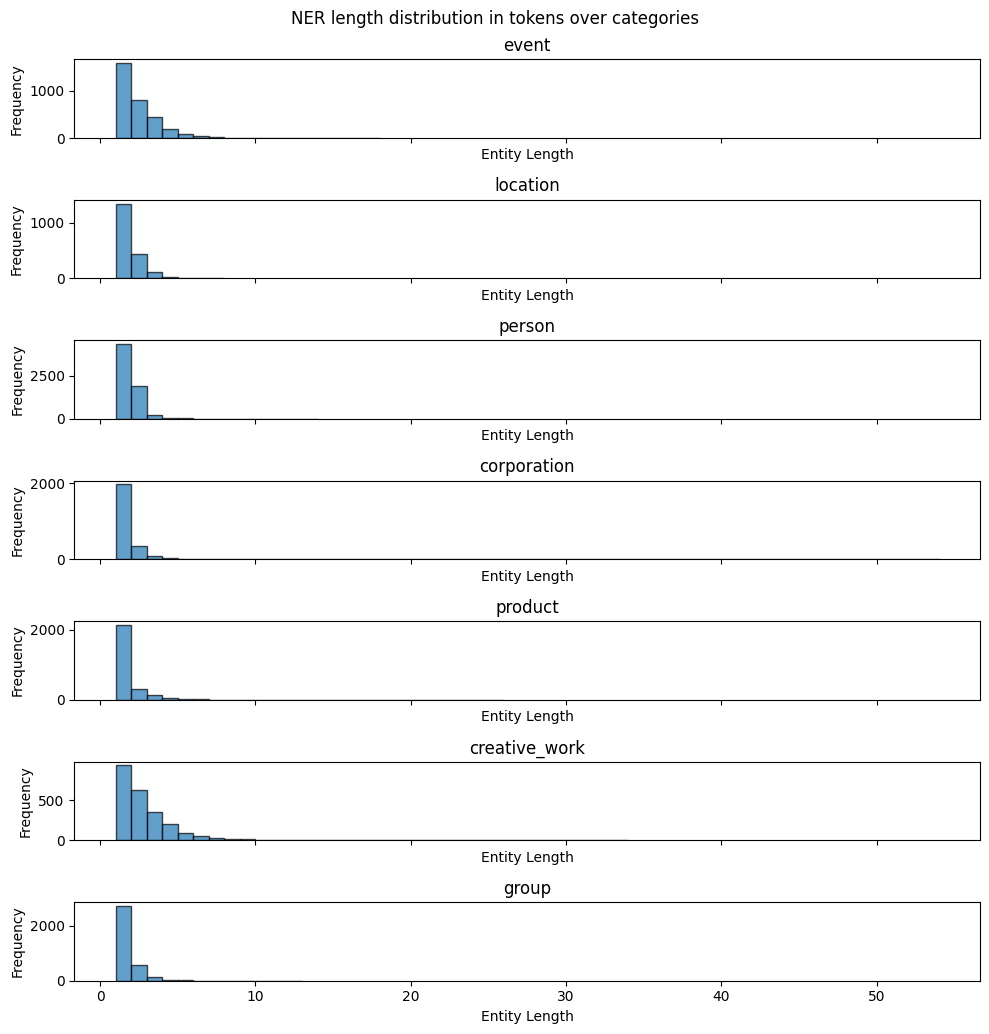

In [61]:
from collections import defaultdict

def extract_entities(tokens, labels):
    entities = defaultdict(list)
    current_entity = []
    current_label = None

    for token, label in zip(tokens, labels):
        if label != 'O':
            if not current_entity or label != current_label:
                if current_entity:
                    entities[current_label].append(len(current_entity))
                current_entity = [token]
                current_label = label
            else:
                current_entity.append(token)
        else:
            if current_entity:
                entities[current_label].append(len(current_entity))
                current_entity = []
                current_label = None

    if current_entity:
        entities[current_label].append(len(current_entity))

    return entities

all_entities = defaultdict(list)
for _, row in train_df.iterrows():
    entities = extract_entities(row['tokens'], row['labels'])
    for entity_type, lengths in entities.items():
        all_entities[entity_type].extend(lengths)


num_categories = len(all_entities)
fig, axes = plt.subplots(nrows=num_categories, ncols=1, figsize=(10, 1.5 * num_categories), sharex=True)

for ax, (entity_type, lengths) in zip(axes, all_entities.items()):
    ax.hist(lengths, bins=range(1, max(lengths)+2), alpha=0.7, edgecolor='black')
    ax.set_title(entity_type)
    ax.set_xlabel('Entity Length')
    ax.set_ylabel('Frequency')

fig.suptitle('NER length distribution in tokens over categories')
plt.tight_layout()
plt.show()

Longer entities typically tend to be events and creative work. On the contrary, "corporation" and "location" categories less often have big number of tokens.

### How many tokens belong to NER?

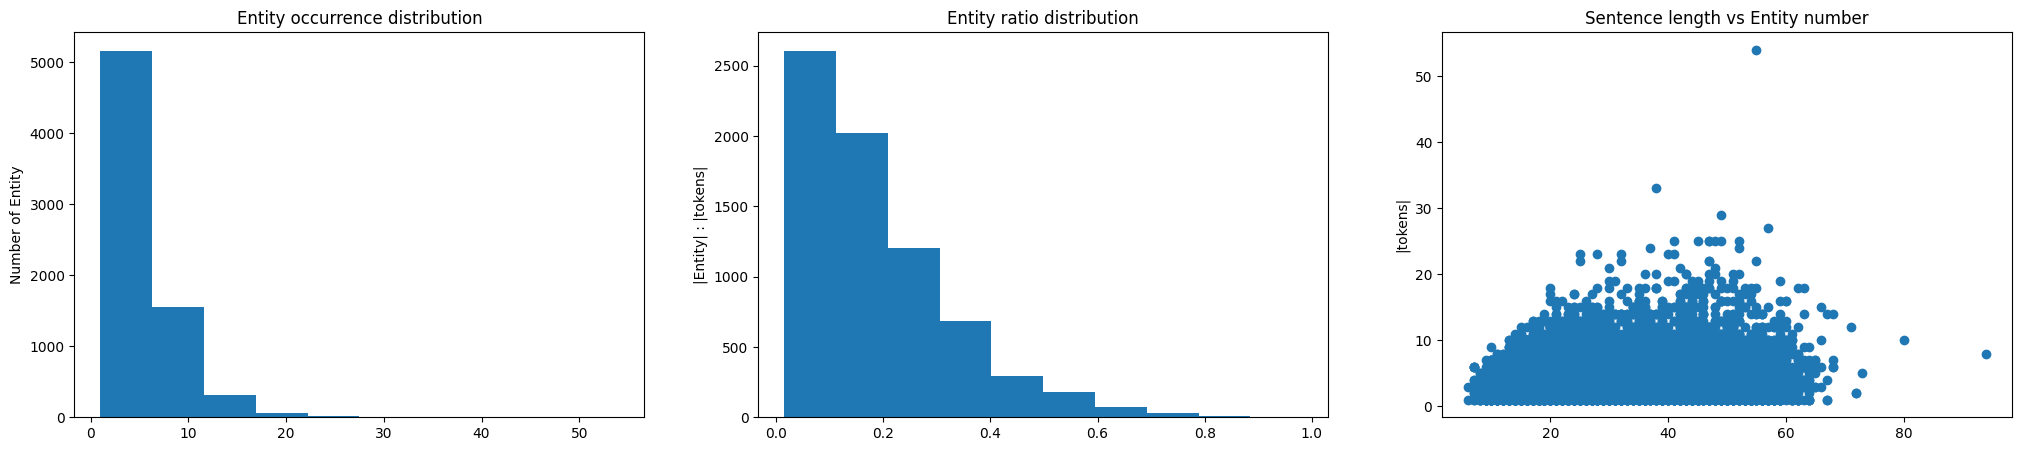

In [62]:

non_pii_count = train_df.labels.apply(lambda x: x.count('O'))
pii_count = train_df.labels.apply(len) - non_pii_count
pii_ratio = pii_count / train_df.labels.apply(len)


fig, axes = plt.subplots(1, 3, figsize=(25, 5))
axes[0].hist(pii_count)
axes[0].set_title('Entity occurrence distribution')
axes[0].set_ylabel('Number of Entity')

axes[1].hist(pii_ratio)
axes[1].set_title('Entity ratio distribution')
axes[1].set_ylabel('|Entity| : |tokens|')

axes[2].scatter(train_df.labels.apply(len), pii_count)
axes[2].set_title('Sentence length vs Entity number')
axes[2].set_ylabel('|Entity|')
axes[2].set_ylabel('|tokens|')

plt.show()

In [65]:
import numpy as np

print('Среднее количество сущностей в тексте:', pii_count.mean(), 'Максимальное количество: ', pii_count.max())
print('Коэффициент корреляции длины и кол-ва NE:', np.corrcoef(pii_count, train_df.labels.apply(len))[0, 1])

Среднее количество сущностей в тексте: 5.081001265644776 Максимальное количество:  54
Коэффициент корреляции длины и кол-ва NE: 0.1596908042669673


In about half of the cases, entities make up about half of all tokens. 

Expectedly, the longer the text, the more entities it may contain. However, after a certain length threshold (around 15 tokens), the rate of NER ratio increase slows down. 

### Categories distribution

In [5]:
def plot_categ_distribution(data, ax, title):
    labels_dict = dict(zip(labels_list, [0] * len(labels_list)))

    def count_labels(tokens):
        for token in tokens:
            if token in id_2_label:
                labels_dict[id_2_label[token]] += 1

    data['labels'].apply(count_labels)
    ax.bar(labels_dict.keys(), labels_dict.values())
    ax.set_title(title)

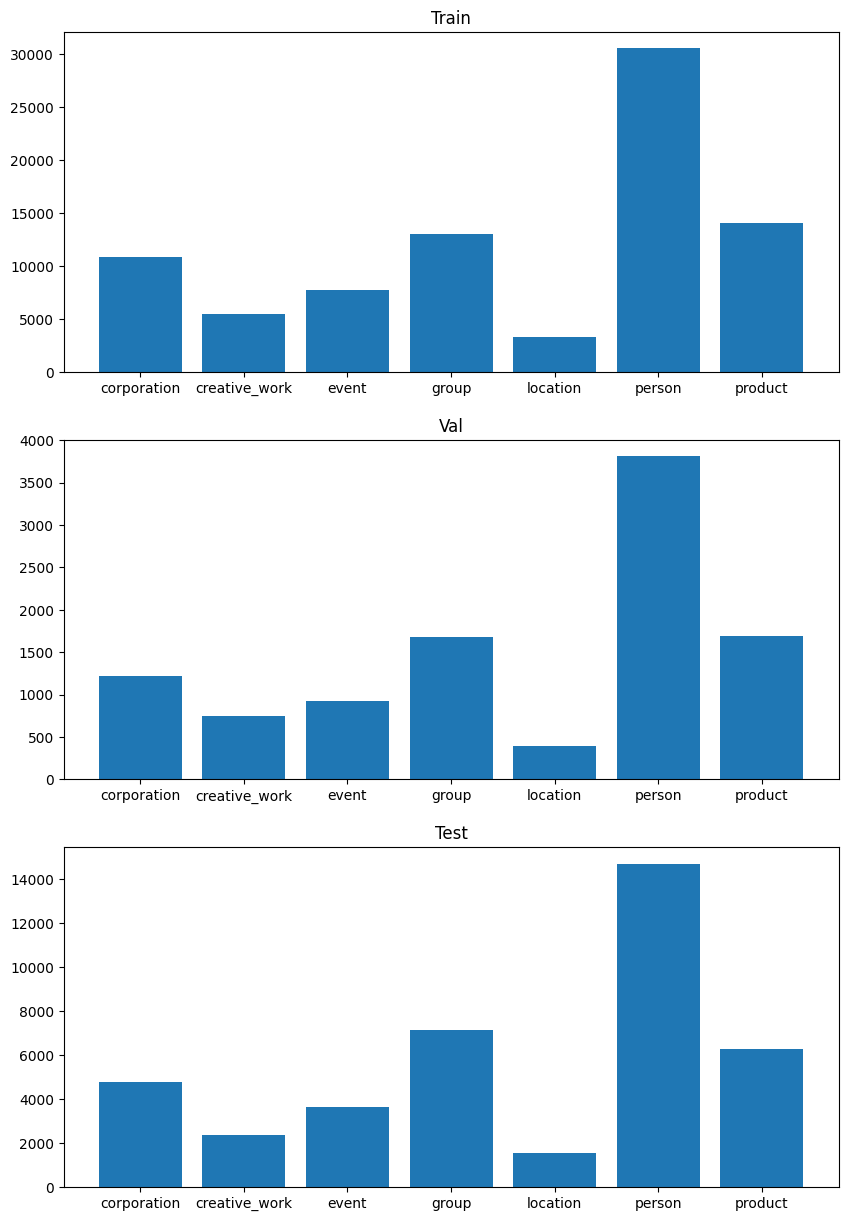

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

plot_categ_distribution(train_dataset_tokenized, axes[0], 'Train')
plot_categ_distribution(val_dataset_tokenized, axes[1], 'Val')
plot_categ_distribution(test_dataset_tokenized, axes[2], 'Test')

As we can see, distribution of categories imbalanced, but equal for all data subsets.

### Which entities tend to co-occur more often?

7111it [00:01, 4016.15it/s]


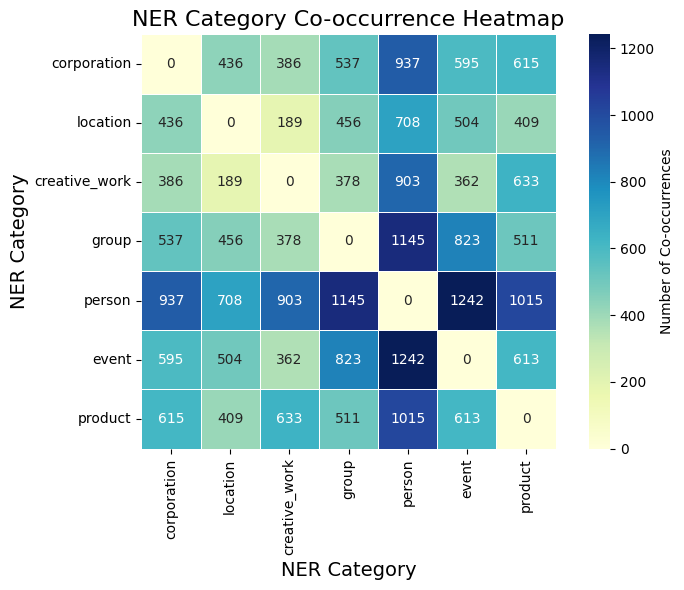

In [74]:
import seaborn as sns
from tqdm import tqdm

categories = list(labels)


def plot_cooccurrence(data: pd.DataFrame) -> None:
    co_occurrence = pd.DataFrame(0, index=categories, columns=categories)

    for _, row in tqdm(data.iterrows()):
        sentence_labels = set(label.split('-')[-1] for label in row['labels'] if label != 'O')
        for cat1 in sentence_labels:
            for cat2 in sentence_labels:
                if cat1 == cat2:
                    continue
                if cat1 in categories and cat2 in categories:
                    co_occurrence.loc[cat1, cat2] += 1

    plt.figure(figsize=(8, 6))
    sns.heatmap(co_occurrence, annot=True, cmap="YlGnBu", fmt="d", square=True,
                cbar_kws={'label': 'Number of Co-occurrences'}, linewidths=0.5)
    plt.title("NER Category Co-occurrence Heatmap", fontsize=16)
    plt.xlabel("NER Category", fontsize=14)
    plt.ylabel("NER Category", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_cooccurrence(train_df)

We see that "person" often co-occurs with "group" and "events", and a little less often with "product".
"Creative work" and "location" rarely ever meet in the same text. 

### POS description

In [88]:
import spacy
from spacy.tokens import Doc

nlp = spacy.load("en_core_web_sm")

docs = train_df.tokens.apply(lambda tokens: nlp(Doc(nlp.vocab, tokens)))

In [90]:
from collections import defaultdict
import seaborn as sns

def extract_pos_distribution(data: pd.DataFrame,
                             preds: list[spacy.tokens.Doc]) -> defaultdict:
  pos_distribution = defaultdict(lambda: defaultdict(int))
  pos_tags = [[token.pos_ for token in document] for document in preds]
  for idx, row in data.iterrows():
      for token, label, pos in zip(row['tokens'], row['labels'], pos_tags[idx]):
          if label != 'O':
              entity_type = label.split('-')[-1]
              pos_distribution[entity_type][pos] += 1

  return pos_distribution


def visualize_pos_distribution(pos_distribution: defaultdict) -> None:
  pos_df = pd.DataFrame(pos_distribution).fillna(0).T.astype(int)
  plt.figure(figsize=(14, 10))
  sns.heatmap(pos_df, annot=True, fmt="d", cmap="Blues",
              cbar_kws={'label': 'Frequency'}, linewidths=0.5,
              annot_kws={"size": 10})

  plt.title("PoS Distribution for each NER Category", fontsize=16)
  plt.ylabel("NER Categories", fontsize=14)
  plt.xlabel("POS Tags", fontsize=14)
  plt.xticks(rotation=45, fontsize=12)
  plt.yticks(fontsize=12)
  plt.tight_layout()
  plt.show()

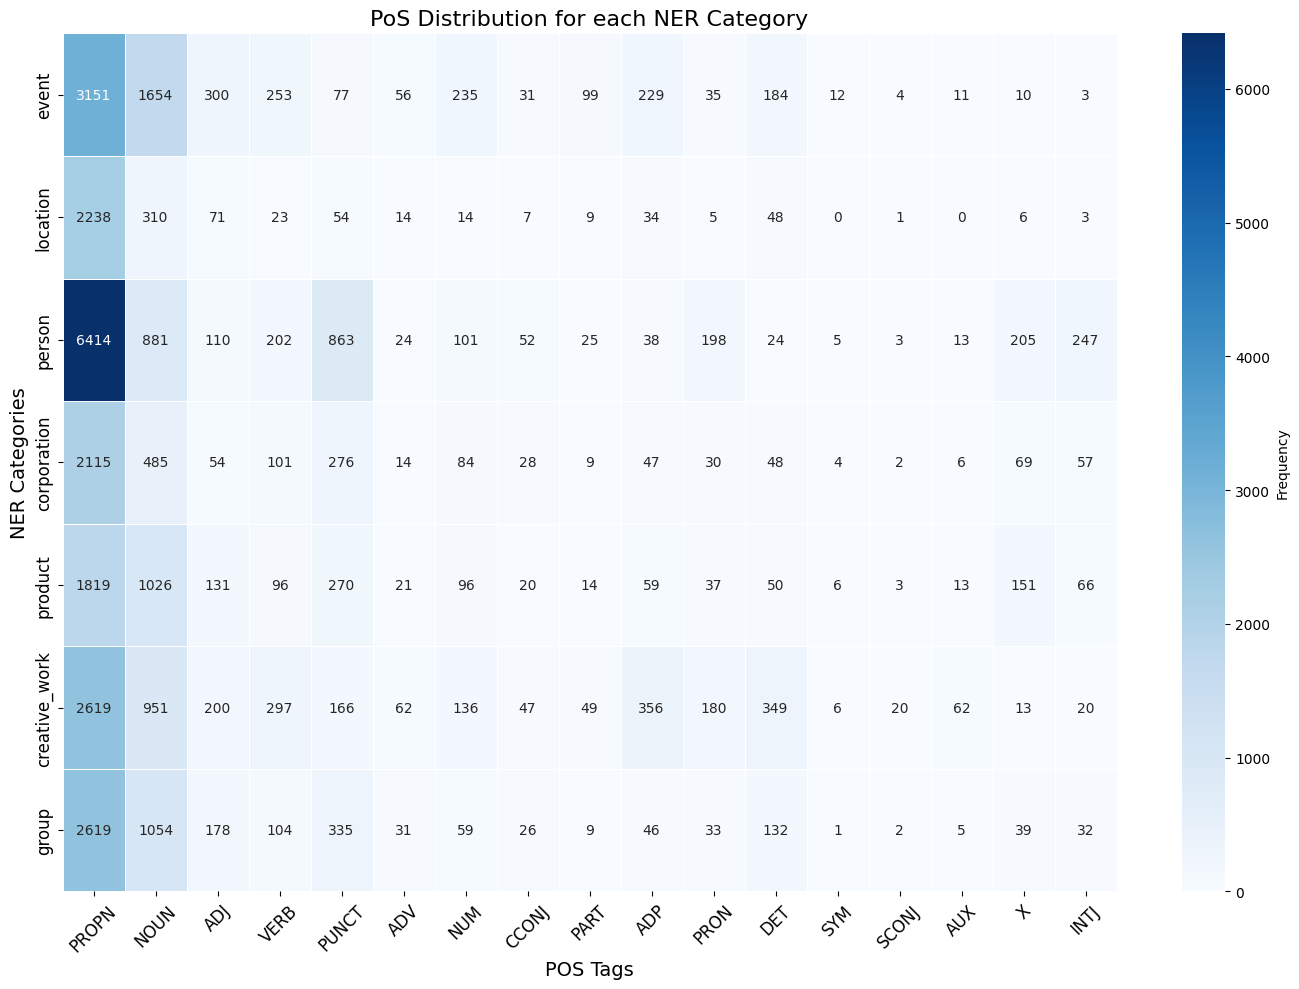

In [91]:
train_pos_distr = extract_pos_distribution(train_df, docs)
visualize_pos_distribution(train_pos_distr)

The vast majority of named entities have proper nouns in them, but it is especially prominent in NERs of the type "person". Second most common across all categories part of speech is noun.
Punctuation is more often present in "person" entities. Aspositions and articles can me a marker for creative work.

## BERT training

In [7]:
import evaluate

from backend.data_utils import create_dataset, DataCollator, NERDataset
from backend.model_utils import create_model
from backend.training_utils import Trainer

from transformers import AutoTokenizer, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW


torch.manual_seed(0)
save_path = './checkpoints/bert_base'

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = create_model(model_name, label_2_id)

train_ner_dataset = NERDataset(train_dataset_tokenized)
val_ner_dataset = NERDataset(val_dataset_tokenized)
test_ner_dataset = NERDataset(test_dataset_tokenized)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
collator = DataCollator(token_pad_id=tokenizer.pad_token_id)
train_dataloader = DataLoader(train_ner_dataset, batch_size=32, shuffle=True, collate_fn=collator, drop_last=True)
val_dataloader = DataLoader(val_ner_dataset, batch_size=64, shuffle=False, collate_fn=collator, drop_last=False)

In [10]:
lr = 1e-4
weight_decay = 1e-07
epochs = 30
warmup_steps =  0.3 * epochs * len(train_dataloader)

optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, epochs * len(train_dataloader))

trainer = Trainer(model, optimizer, train_dataloader, val_dataloader,
                  device=device, scheduler=scheduler)

losses = trainer.train(epochs, save_path)

Start training


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.60it/s]


Epoch: 0, Mean loss: 1.1777467089998832


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.61it/s]


Epoch: 1, Mean loss: 0.477963146862683


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.57it/s]


Epoch: 2, Mean loss: 0.38073252819411374


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.55it/s]


Epoch: 3, Mean loss: 0.3136813282161146


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.48it/s]


Epoch: 4, Mean loss: 0.2508383108688904


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.53it/s]


Epoch: 5, Mean loss: 0.198216737289955


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.56it/s]


Epoch: 6, Mean loss: 0.15814348212904764


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.50it/s]


Epoch: 7, Mean loss: 0.13177109607033902


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:30<00:00,  7.36it/s]


Epoch: 8, Mean loss: 0.11216027257745868


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:30<00:00,  7.35it/s]


Epoch: 9, Mean loss: 0.09123354635058761


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.51it/s]


Epoch: 10, Mean loss: 0.07402507334041439


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.51it/s]


Epoch: 11, Mean loss: 0.0568544716901473


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.52it/s]


Epoch: 12, Mean loss: 0.04529677431711604


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.52it/s]


Epoch: 13, Mean loss: 0.0369997055244607


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.57it/s]


Epoch: 14, Mean loss: 0.02877900145134074


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.52it/s]


Epoch: 15, Mean loss: 0.023239116930100768


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.53it/s]


Epoch: 16, Mean loss: 0.018706430398926197


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.52it/s]


Epoch: 17, Mean loss: 0.014855484468736552


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.49it/s]


Epoch: 18, Mean loss: 0.012208606078717349


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.43it/s]


Epoch: 19, Mean loss: 0.010586217392670195


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.54it/s]


Epoch: 20, Mean loss: 0.007866921659238087


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.49it/s]


Epoch: 21, Mean loss: 0.006581728890572824


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.50it/s]


Epoch: 22, Mean loss: 0.005300121211975413


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.46it/s]


Epoch: 23, Mean loss: 0.0038743619398037715


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.45it/s]


Epoch: 24, Mean loss: 0.002573825693698464


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.53it/s]


Epoch: 25, Mean loss: 0.0020115561445080052


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.54it/s]


Epoch: 26, Mean loss: 0.00187911032510267


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.51it/s]


Epoch: 27, Mean loss: 0.0014544180118169962


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.49it/s]


Epoch: 28, Mean loss: 0.0012053789661778758


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:29<00:00,  7.52it/s]


Epoch: 29, Mean loss: 0.0008981851685209081


In [11]:
def calculate_metrics(predictions: list[str], labels: list[str]):
    metric = evaluate.load("seqeval")
    predictions_adj = [predictions[i] for i in range(len(predictions)) if len(predictions[i]) == len(labels[i])]
    labels_adj = [labels[i] for i in range(len(labels)) if len(predictions[i]) == len(labels[i])]
    metrics = metric.compute(predictions=list(predictions_adj), references=labels_adj)
    metrics_class = {k: metrics[k] for k in labels_list}
    metrics_global = {k: metrics[k] for k in global_metrics}
    print(pd.DataFrame(metrics_class), '\n')
    print(pd.DataFrame([metrics_global], columns=list(metrics_global.keys()), index=['Value']))

In [13]:
import os
from backend.validation_utils import inference


best_model = torch.load(os.path.join(save_path, 'best_model.pth'), weights_only=False).to(device).eval()
val_dataloader = DataLoader(val_ner_dataset, batch_size=1, shuffle=False, collate_fn=collator, drop_last=False)
model_preds = inference(best_model, val_dataloader, val_dataset_tokenized['word_inds'], {v: k for k, v in label_2_id.items()}, device=device)

calculate_metrics(model_preds, val_dataset['bio_labels'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 886/886 [00:02<00:00, 321.20it/s]


           corporation  creative_work       event       group    location  \
precision     0.498361       0.428571    0.394737    0.559551    0.576208   
recall        0.500000       0.446809    0.348837    0.548458    0.612648   
f1            0.499179       0.437500    0.370370    0.553949    0.593870   
number      304.000000     282.000000  387.000000  454.000000  253.000000   

               person     product  
precision    0.831002    0.637931  
recall       0.809308    0.632479  
f1           0.820012    0.635193  
number     881.000000  351.000000   

       overall_precision  overall_recall  overall_f1  overall_accuracy
Value           0.612373        0.601648    0.606963          0.908093
